# STAT4609 Assignment 6:  Gibbs sampling algorithm for Latent Dirichlet Allocation. 

In this assignment, we are going to understand the idea of latent Dirichlet allocation (LDA), a flexible model to estimate the properties of text. On the example of
LDA, the usage of Gibbs sampling is shown as a straight-forward means of approximate
inference in Bayesian networks. 


## Part 1: Reading and Short Essay

### Please read the following paper via [this link](https://www.pnas.org/content/101/suppl_1/5228).

    Griffiths, Thomas L., and Mark Steyvers. "Finding scientific topics." Proceedings of the National academy of Sciences 101.suppl 1 (2004): 5228-5235.



The notations in the aforementioned reference varies. Please be careful when you are reading. 



### Please write a short essay to describe the following subjects, 
1. The probabilistic graphcial models and dependencies for LDA model. Please define notations before refering to.  
2. The Gibbs sampling update steps for the parameters of LDA. Deriving the update steps should be straightforward after writing the dependencies of the parameters in the graphical model.
3. The goal of Gibbs Sampling for the inference Latent Dirichlet Allocation? 


**Optional**

If you would like to know more about the mathematical and technical details, please read **Section 5**, [Parameter estimation for text analysis](http://www.arbylon.net/publications/text-est.pdf).

Please note that all the comments and notations in this jupyter notebook follows this reference for your convenience.

In [2]:
%matplotlib inline

## Part 2 Implementation of LDA and Inference via Gibbs sampling for LDA 
Although latent Dirichlet allocation is still a relatively simple model, exact inference is generally intractable. The solution to this is to use approximate inference algorithms. Gibbs sampling is a special case of Markov-chain Monte Carlo (MCMC) simulation and often yields relatively simple algorithms for approximate inference in high-dimensional models such as LDA. Therefore we select this approach and present a derivation that is more detailed than the original one by Griffiths and Steyvers. 


To derive a Gibbs sampler for LDA, we apply the hidden-variable method from above. The hidden variables in our model are $z_{d, w}$, i.e., the topic that appear with the word $w$ in document $d$ . We do not need to include, i.e., can integrate out, the parameter sets $\Theta$ and $\Phi$ because they can be interpreted as statistics of the associations between the observed word and the corresponding topic, the state variables of the Markov chain. 

In this assignment, we will use Gibbs sampling for LDA. 
distribution. During the inference, the distribution of topics in docuemnts, $\mathbf{\theta}$, the distribution of words in topics $\mathbf{\phi}$, and likelihood 
$p(\mathbf{w}|\mathbf{z})$ are estimated. 


### Settings
1. we have $T$ topics
2. The copus are consist of $D$ documents, and there are $W$ words within each document $d$. 
3. For dirichlet distribution of $\mathbf{\phi}$, the the number of prior parameters are equal to the number of vocabulary. The prior parameters are all of the same value, $\beta$. 
4. For dirichlet distribution of $\mathbf{\theta}$, the the number of prior parameters are equal to the number of topics. The prior parameters are all of the same value, $\alpha$. 

###  Argument Definitions and Types 



```
z: z must take in (d,w,i) as input, corresponding to 
    topic indicator for i-th obserevation of word w in doc d.
    z is a python dictionary. 
```
```
topic_word_matrix: of dimension (T, W).  
    It refers to the topic of each word. t-th row of topic_word_matrix corresponds to the word observation counts for topic $t$. 

```     
In the first reference, ```topic_word_matrix[j, w]``` is noted as $n_j^{(w)}$, which is the number of times word $w$ has been assigned
to topic $j$. 


```
doc_topic_matrix: of dimension (D, T). It refers to the topic counts for each document. 

```
```doc_topic_matrix[d, j]``` is noted as $n_j^{(d)}$ the number of times a word from document $d$ has been assigned to topic $j$.  


```
topic_counts: the total number of words has been assigned to each topic. 
```



```
doc_counts: document topic sum 
```


log_likelihood corresponding to the $log(p(\mathbf{w}|\mathbf{z}))$. $p(\mathbf{w}|\mathbf{z})$ is equation [2] in the first reference. 




In [18]:
"""
LDA implementation in Python

@author: Michael Zhang
"""

import matplotlib.pyplot as plt
import numpy as np
import scipy

class LDA(object):
    
    def __init__(self, tdm, T, alpha = 1., beta=1., iteration=100):
        """
        tdm: the copus, of (D, Num_words_in_corpus), 
            the value of each entry is the counts of corresponding words in this the corresponding document.
            e.g.
            tdm[d, w] = number of word w appears in document d. 
        T: the number of topics 
        
        """
        self.tdm = tdm
        self.D, self.W = self.tdm.shape             
        self.alpha= alpha # count for expected value for hyper parameter alpha of theta, i.e. document-topic distribution.
        self.beta = beta # count for expected value for hyper parameter beta topic-word distribution.
        self.T = T 
        self.iteration = iteration
        
        # z must take in (d,w,i) as input, corresponding to 
        # topic indicator for i-th obserevation of word w in doc d
        self.z = {} 
        self.topic_word_matrix = np.zeros((self.T, self.W)) # initialize the topic-word matrix.
        self.doc_topic_matrix = np.zeros((self.D, self.T)) # initialize the documnet-topic matrix.
        self.topic_counts = np.zeros(self.T) # initialize the topic counter for after sampling process, should be sum of value in self.topic_word_matrix
        self.doc_counts = np.zeros(self.D) # initialize the doc counter for after sampling process, should be sum of value in self.doc_topic_matrix
        self.log_likelihood = np.zeros(self.iteration) # store the value of log likelihood at each iteration
        self._init_matrix()
        
        
    # @pysnooper.snoop('init.log')    
    def _init_matrix(self):
        """
        for all words
        1. sample a topic randomly from T topics for each word 
        2. increment topic word count, self.topic_word_matrix
        3. increment document topic count,  self.doc_topic_matrix 
        4. update the topic indicator z. 
        """
        for d in range(self.D): 
            doc = scipy.sparse.coo_matrix(self.tdm[d])
            word_freq_topic = zip(doc.col, doc.data)
            for w, frequency in word_freq_topic: # (word, freq)
                for i in range(frequency):
                    ############ Finish the following initialization steps #############
                    # 1. sample a topic randomly from T topics for each word 
                    topic = np.random.randint(self.T)
                    # 2. increment topic word count, self.topic_word_matrix
                    self.topic_word_matrix[topic, w] += 1
                    # 3. increment document topic count,  self.doc_topic_matrix 
                    self.doc_topic_matrix[d, topic] += 1
                    # 4. update the topic indicator z. 
                    self.z[(d, w, i)] = topic # d: document ID; w: word ID: i: instance ID，即在d中第几个w

      
        self.topic_counts = self.topic_word_matrix.sum(axis=1)
        self.doc_counts = self.doc_topic_matrix.sum(axis=1)

    def fit(self):
        for it in range(self.iteration):
            # iterate over all the documents
            for d in range(self.D):
            # iterate over all the words in d
                for w in self.tdm[d].indices: 
                    # iterate over number of times observed word w in doc d
                    for i in range(self.tdm[d, w]):
                        # we apply the hidden-varible method of Gibbs sampler, the hidden variable is z[(d,w,i)]
                        self.doc_topic_matrix[d,self.z[(d,w,i)]] -= 1
                        self.doc_counts[d] -= 1
                        self.topic_word_matrix[self.z[(d,w,i)],w] -= 1
                        self.topic_counts[self.z[(d,w,i)]] -= 1

                        # estimation of phi and theta for the current corpus 
                        phi_hat = (self.topic_word_matrix[:, w] + self.beta) / (self.topic_counts + self.beta * self.W)
                        theta_hat = (self.doc_topic_matrix[d, :] + self.alpha) / (self.doc_counts[d] + self.alpha * self.T)

                        # calculate the full conditional distribution
                        full_conditional = phi_hat * theta_hat
                        # normalize full_conditional such that it summation equals to 1. 
                        full_conditional = full_conditional / full_conditional.sum()
                        # sample a topic for i-th obserevation of word w in doc d based on full_conditional
                        new_topic = np.random.multinomial(1, full_conditional).argmax()
                        
                        # update z, doc_topic_matrix, doc_counts, topic_word_matrix, topic_counts here. 
                        self.z[(d,w,i)] = new_topic

                        self.doc_topic_matrix[d,self.z[(d,w,i)]] += 1
                        self.topic_word_matrix[self.z[(d,w,i)],w] += 1
                        self.doc_counts[d] += 1
                        self.topic_counts[self.z[(d,w,i)]] += 1
                        ############################################################


            # Equation 2  log P(w|z)  for each iteration based on Equation [2]
            ## +++++++++ insert code below ++++++++++++++++++++++++###
            self.log_likelihood[it] = 0
            for k in range(self.T):
                for w in range(self.W):
                    self.log_likelihood[it] += self.topic_word_matrix[k,w] * np.log((self.topic_word_matrix[k,w] + self.beta) / (self.topic_counts[k] + self.beta * self.W))
            ############################################################
            print('Iteration %i\t LL: %.2f' % (it,self.log_likelihood[it]))
        self.theta = (self.doc_topic_matrix + self.alpha) / (self.doc_counts[:,np.newaxis] + self.alpha * self.T)
        self.phi = (self.topic_word_matrix + self.beta) / (self.topic_counts[:,np.newaxis] + self.beta * self.W)



### Experiment 1: Well separated synthetic dataset. 

This synthetic dataset consists of 100 documents, and 500 words as total number of vocabulary There are 5 topics in total. 

In this experiment, you are not required to write any additional code. Run the following code, and see if your topic_word_matrix could resemble true "phi", i.e. the true distribution of words in each topic, up to reordering. 



In [19]:
# dataloading 
from sklearn import datasets
from sklearn.feature_extraction.text import CountVectorizer


synthetic_data = scipy.io.loadmat('well_separated_synthetic.mat')
sk_tdm = scipy.sparse.csr_matrix(synthetic_data['W'])
sk_tdm # of shape 100 \times 500 

<100x500 sparse matrix of type '<class 'numpy.intc'>'
	with 8552 stored elements in Compressed Sparse Row format>

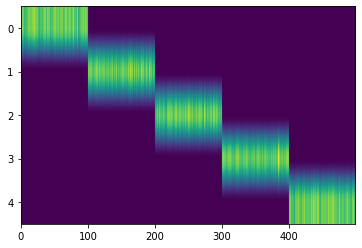

In [20]:

# first run LDA on synthetic data set, 
# if code works then topic_word_matrix should 
# resemble true "phi", up to reordering

# distribution of words in 5 topics, 
plt.imshow(synthetic_data['phi'],aspect='auto')


In [21]:
# run LDA with 5 topics on synthetic data set
lda = LDA(sk_tdm, T=5, iteration=100)
lda.fit()


Iteration 0	 LL: -58951.28
Iteration 1	 LL: -58316.75
Iteration 2	 LL: -58020.06
Iteration 3	 LL: -57764.63
Iteration 4	 LL: -57790.21
Iteration 5	 LL: -57810.85
Iteration 6	 LL: -57699.38
Iteration 7	 LL: -57566.27
Iteration 8	 LL: -57356.45
Iteration 9	 LL: -57314.97
Iteration 10	 LL: -57211.19
Iteration 11	 LL: -57078.47
Iteration 12	 LL: -56922.51
Iteration 13	 LL: -56818.92
Iteration 14	 LL: -56717.99
Iteration 15	 LL: -56650.16
Iteration 16	 LL: -56801.16
Iteration 17	 LL: -56910.37
Iteration 18	 LL: -56716.04
Iteration 19	 LL: -56553.19
Iteration 20	 LL: -56526.79
Iteration 21	 LL: -56496.45
Iteration 22	 LL: -56248.54
Iteration 23	 LL: -56215.66
Iteration 24	 LL: -56084.99
Iteration 25	 LL: -56052.85
Iteration 26	 LL: -55952.92
Iteration 27	 LL: -55749.12
Iteration 28	 LL: -55837.06
Iteration 29	 LL: -55826.46
Iteration 30	 LL: -55767.60
Iteration 31	 LL: -55776.16
Iteration 32	 LL: -55728.58
Iteration 33	 LL: -55618.20
Iteration 34	 LL: -55687.75
Iteration 35	 LL: -55687.47
It

In [25]:
lda.phi

array([[0.00114811, 0.0003827 , 0.0003827 , ..., 0.0003827 , 0.00267891,
        0.0007654 ],
       [0.00621118, 0.00496894, 0.01200828, ..., 0.00289855, 0.00082816,
        0.00289855],
       [0.0004279 , 0.0004279 , 0.0004279 , ..., 0.0004279 , 0.0008558 ,
        0.0012837 ],
       [0.00036036, 0.00144144, 0.00072072, ..., 0.0036036 , 0.0036036 ,
        0.00900901],
       [0.00127119, 0.00084746, 0.00042373, ..., 0.00084746, 0.00042373,
        0.00084746]])

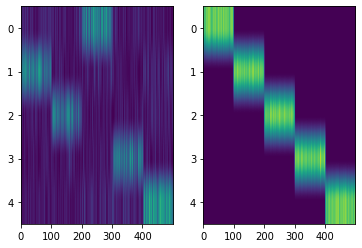

In [5]:
# compare LDA topic word matrix and true topic word distribution
f,a = plt.subplots(1,2)

a[0].imshow(lda.topic_word_matrix, aspect='auto')
a[1].imshow(synthetic_data['phi'], aspect='auto')

### Experiment 2.

In this experiment, we use a real-world dataset, with 20 topics (newsgroups). 
1. you need to build and fit LDA model. 
2. get top 10 words in each topic, (should make sense) 
3. plot train loglikelihood, i.e. equation [2] in the reference paper, (should increase over iterations)




In [6]:
# data loading 
# create term document matrix, documents from collection of 20 newsgroups
count_vector = CountVectorizer(stop_words="english", 
                                min_df=.01, 
                                max_df=.95)
data_set = datasets.fetch_20newsgroups()
sk_tdm = count_vector.fit_transform(data_set['data'])


In [7]:
# get list of words in corpus
corpus_words = np.array(count_vector.get_feature_names())    


d:\Anaconda\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [8]:
# run LDA with 20 topics on 20 news groups dataset
lda = LDA(sk_tdm, T=20, iteration=100)
lda.fit()

Iteration 0	 LL: -7052701.42
Iteration 1	 LL: -6996604.83
Iteration 2	 LL: -6939801.15
Iteration 3	 LL: -6878068.69
Iteration 4	 LL: -6794254.73
Iteration 5	 LL: -6675505.85
Iteration 6	 LL: -6537656.34
Iteration 7	 LL: -6403307.61
Iteration 8	 LL: -6295052.97
Iteration 9	 LL: -6214928.68
Iteration 10	 LL: -6149313.94
Iteration 11	 LL: -6099245.15
Iteration 12	 LL: -6061062.22
Iteration 13	 LL: -6027147.33
Iteration 14	 LL: -6000143.61
Iteration 15	 LL: -5979264.33
Iteration 16	 LL: -5961255.88


KeyboardInterrupt: 

In [ ]:
# get top 10 words in each topic, should make sense


In [ ]:
# plot train loglikelihood, should increase over iterations
